author FBB for MLTSA2020

# Autoencoder notebook 
create superresolution portraits from low resolution black and white images:
- load a patch of images and lower the resolution
- build an autoencoder with a bottleneck layer much smaller thn the number of pixels in an image
- pass the lower resolution images as imput and the higher resolution images as output
- ask the encoder to predict high resolution images from low resolution ones
- test it on a headshot of yourself

In [2]:
from google.colab import drive

drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
from keras.models import Sequential
from keras.layers import Dense#, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


Using TensorFlow backend.


In [4]:
import glob
import h5py
from PIL import Image
import numpy as np
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
cd /content/gdrive/My\ Drive


/content/gdrive/My Drive


In [6]:
cd MLTSA2020/

/content/gdrive/My Drive/MLTSA2020


# load head shots from known training data
The first time you will need to dowbload faces95.zip. Uncomment the 2 lines of code below

In [0]:
#!wget https://cswww.essex.ac.uk/mv/allfaces/faces95.zip

In [0]:
#!unzip faces95.zip

In [0]:
#!ls faces95/*/*jpg

In [0]:
flist = glob.glob("faces95/*/*jpg")

In [8]:
N = len(flist)
N

1440


## read in data

if you save the data in a npy array you can read it in more quickly. After the first time you run this you can comment out the next 2 cells of code and skip to the np.load command

((70, 70, 1), 540)

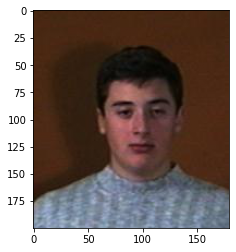

In [14]:
im = Image.open(flist[0])
np_im = numpy.array(im)[:,:,:3].astype(float) / 255 #normalize the images so that they are 0-1
pl.imshow(np_im)
# I am going to need only a subset of the image: the center part where the head is

np_im[25:165:2,25:165:2,:1].shape, np.prod(np_im.shape[1:])

In [15]:
#skip and read the saved version if you have saved it (after the first time you run this cell)
imgs = np.zeros((N, 70, 70, 1))
for i,f in enumerate(flist):
  if not i%50: print(i)
  im = Image.open(flist[i])
  np_im = numpy.array(im)[:,:,:3].astype(float) / 255 
  # here I collect the certain portion of each image 
  # from pixel 25 to 165 on the x and y axis (25:165)
  # and subsampling by a factor 2 (25:165:2)
  # and I am only choosing 1 color layer: [...,:1]: the R in RGB layers
  imgs[i] = numpy.array(im)[25:165:2,25:165:2,:1].astype(float) / 255 
np.save("faces.npy", imgs)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400


In [0]:
# you can read the images below if you have saved them earlier

In [0]:
imgs = np.load("faces.npy")

## make a copy of the original before you lower the resolution#

In [0]:
#imgs orig is the full resolution image
imgs_orig = imgs.copy()

In [11]:
# lower the resolution
imgs = imgs[:,::2,::2]
imgs[0].shape

(35, 35, 1)

In [12]:
imgs.shape

(1440, 35, 35, 1)

In [13]:
#this is the number of pixels in the image
np.prod(imgs[0].shape)

1225

## generate a train and test set
If I want to predict the image at the same resolution I will pass the same input as the target variable. Otherwise the target variable will be a full resolution image set and the low input the lower resolution one

In [0]:
SUPERRESOLVE = True

In [0]:
from sklearn.model_selection import train_test_split
if SUPERRESOLVE:
  X_tr,  X_te, y_tr, y_te = train_test_split(imgs, imgs_orig, 
                                             test_size = .25, random_state=1)
else:
  X_tr,  X_te, y_tr, y_te = train_test_split(imgs, imgs, 
                                             test_size = .25, random_state=1)
  

In [16]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1080, 35, 35, 1), (360, 35, 35, 1), (1080, 70, 70, 1), (360, 70, 70, 1))

In [0]:
X_tr = X_tr.reshape(len(X_tr), np.prod(X_tr.shape[1:]))
X_te = X_te.reshape(len(X_te), np.prod(X_te.shape[1:]))
y_tr = y_tr.reshape(len(y_tr), np.prod(y_tr.shape[1:]))
y_te = y_te.reshape(len(y_te), np.prod(y_te.shape[1:]))

# build an autoencoder model

In [0]:
def create_model(bottleneck=128, input_dim=1225):
  model = Sequential()
  model.add(Dense(256, activation='relu', input_dim=1225))
  model.add(Dense(128, activation='relu', name="bottleneck"))
  if bottleneck < 128:
    model.add(Dense(bottleneck, activation='relu'))
    model.add(Dense(128, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(1225, activation='relu'))
  model.add(Dense(1225*4, activation='sigmoid'))
  model.compile(optimizer='adamax', loss='mse',
              metrics=['mae', 'acc'])# optimizer="adadelta", loss="kullback_leibler_divergence")
  return model
model = create_model()

In [19]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               313856    
_________________________________________________________________
bottleneck (Dense)           (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1225)              314825    
_________________________________________________________________
dense_4 (Dense)              (None, 4900)              6007400   
Total params: 6,702,001
Trainable params: 6,702,001
Non-trainable params: 0
_________________________________________________________________
None


## train model OR you can skip and load the pretrained I saved for you!
or to read in the saved model skip this cell, or skip the whole section and read a model from http://fbb.space/mltsa/imgreconstruct_10000.h5

In [0]:
# you can skip this and load the saved model
history = model.fit(X_tr, y_tr, epochs=100000, batch_size=16, verbose=1)
model.save("imgreconstruct_100000.h5")

Epoch 1/100000
1080/1080 [==============================] - 2s 2ms/step - loss: 0.0423 - mae: 0.1617 - acc: 0.0000e+00
Epoch 2/100000
1080/1080 [==============================] - 0s 406us/step - loss: 0.0277 - mae: 0.1280 - acc: 0.0019
Epoch 3/100000
1080/1080 [==============================] - 0s 401us/step - loss: 0.0193 - mae: 0.1043 - acc: 0.0019
Epoch 4/100000
1080/1080 [==============================] - 0s 397us/step - loss: 0.0159 - mae: 0.0934 - acc: 0.0037
Epoch 5/100000
1080/1080 [==============================] - 0s 400us/step - loss: 0.0141 - mae: 0.0866 - acc: 0.0028
Epoch 6/100000
1080/1080 [==============================] - 0s 399us/step - loss: 0.0127 - mae: 0.0810 - acc: 0.0028
Epoch 7/100000
1080/1080 [==============================] - 0s 405us/step - loss: 0.0118 - mae: 0.0775 - acc: 0.0019
Epoch 8/100000
1080/1080 [==============================] - 0s 402us/step - loss: 0.0107 - mae: 0.0732 - acc: 0.0037
Epoch 9/100000
1080/1080 [==============================] - 0s

KeyboardInterrupt: ignored

In [0]:
pl.plot(np.array(history.history['loss']))
pl.yscale('log')
pl.xscale('log')


In [23]:
ls

 API_EN.ATM.CO2E.KT_DS2_en_csv_v2_821337.zip
 API_EN.ATM.CO2E.PC_DS2_en_csv_v2_821708.zip
'API_EN.ATM.CO2E.PC_DS2_en_csv_v2_821708.zip (Unzipped Files)'/
'Colab Notebooks'/
 COVID19/
 faces95/
 faces95.zip
 faces.npy
 hw5/
 hw6/
 hw7/
 hw8/
 imgreconstruct_10000.h5
 kaggle.json
 sumo1.JPG


In [0]:
# READ IN THE SAVED MODEL
#!wget http://fbb.space/mltsa/imgreconstruct_10000.h5
model.load_weights("imgreconstruct_10000.h5")

## predict

In [25]:
outim = model.predict(X_te)
outim

array([[0.45757937, 0.45656636, 0.4534666 , ..., 0.05715255, 0.04810482,
        0.04840253],
       [0.2480839 , 0.2406167 , 0.23913023, ..., 0.14397442, 0.14415891,
        0.14269805],
       [0.17470902, 0.1710837 , 0.17191085, ..., 0.20621158, 0.2302462 ,
        0.2407975 ],
       ...,
       [0.37627295, 0.37570077, 0.3764252 , ..., 0.2928264 , 0.29571456,
        0.30115524],
       [0.24955043, 0.24693096, 0.24483982, ..., 0.03933296, 0.04554883,
        0.0419789 ],
       [0.28496295, 0.2911801 , 0.29143408, ..., 0.30726254, 0.30150005,
        0.3008012 ]], dtype=float32)

In [0]:
def compareinout(i, outim, X_tr):
  '''function to plot the input, the prediction and the target in 3 columns
  plots the ith training datum'''
  fig = pl.figure(figsize(10,5))
  ax = fig.add_subplot(131) 
  ax.imshow(X_te[i].reshape(imgs[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(132) 
  ax.imshow(outim[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(133) 
  ax.imshow(y_te[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


1 :	input		   prediction		target


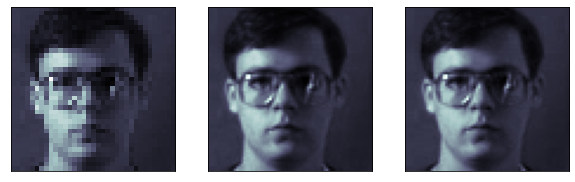

2 :	input		   prediction		target


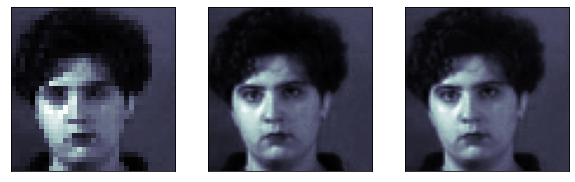

3 :	input		   prediction		target


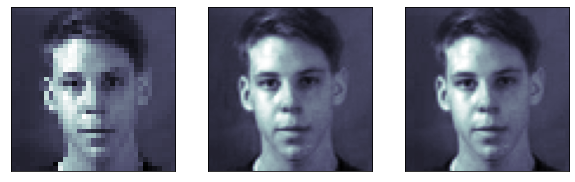

4 :	input		   prediction		target


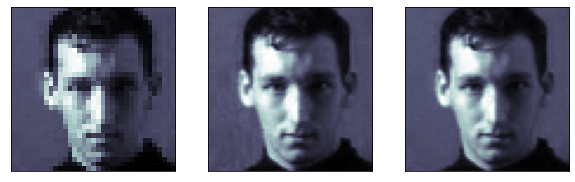

5 :	input		   prediction		target


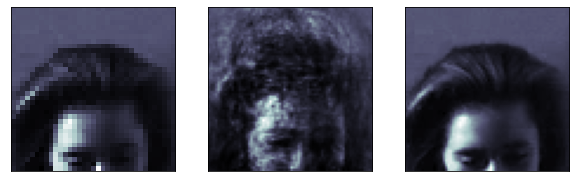

6 :	input		   prediction		target


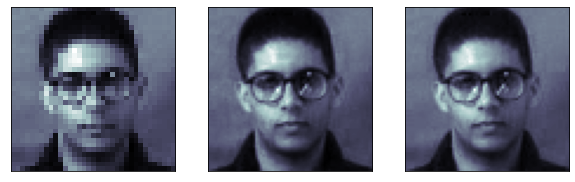

7 :	input		   prediction		target


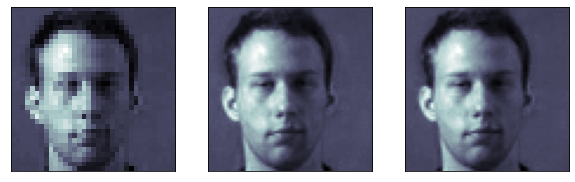

8 :	input		   prediction		target


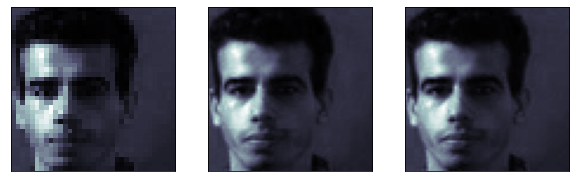

9 :	input		   prediction		target


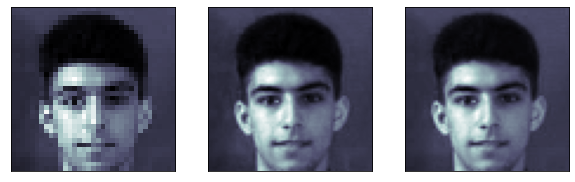

10 :	input		   prediction		target


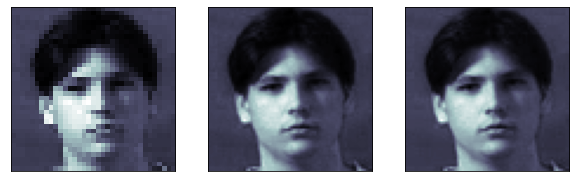

In [27]:
np.random.seed(123)
# pick a few random test images
for i in range(10):
  j = np.random.randint(0, len(X_te))
  print(i + 1, ":\tinput\t\t   prediction\t\ttarget")
  compareinout(j, outim, X_te)
  pl.show()

What do you think? some are pretty good right?! e.g. 1, 4, 6, 7, 8

Some are really bad. 9... why?

## show the latent representation of the data: the bottleneck layer output

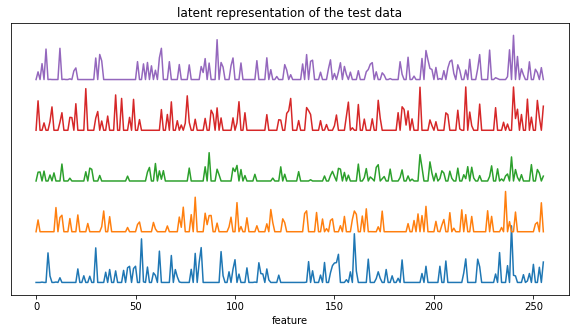

In [28]:
from keras import backend as K
# input placeholder
inp = model.input                   
# extract the bottle neck outputs
outputs = model.layers[2].output     
# create a function to evaluate the output of the bottle neck layer for a given input
functors = K.function([inp], [outputs])    

# Testing
layer_outs = functors(X_te[:5])
  
for i in range(5):
  pl.plot(layer_outs[0][i] + i)

pl.xlabel("feature")
pl.yticks([],"")
pl.title("latent representation of the test data");

# test the model on your own image
 depending on the initial size you will have to downsample the image, and extract a single color layer

In [36]:
ls

 API_EN.ATM.CO2E.KT_DS2_en_csv_v2_821337.zip
 API_EN.ATM.CO2E.PC_DS2_en_csv_v2_821708.zip
'API_EN.ATM.CO2E.PC_DS2_en_csv_v2_821708.zip (Unzipped Files)'/
'Colab Notebooks'/
 COVID19/
 faces95/
 faces95.zip
 faces.npy
 hw5/
 hw6/
 hw7/
 hw8/
 imgreconstruct_10000.h5
 kaggle.json
 sumo1.JPG
 TestIm.jpg


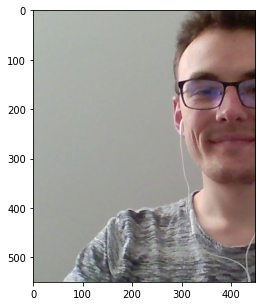

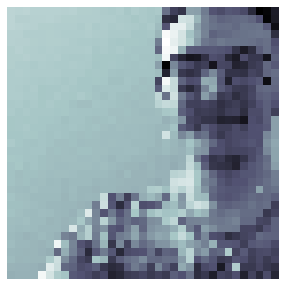

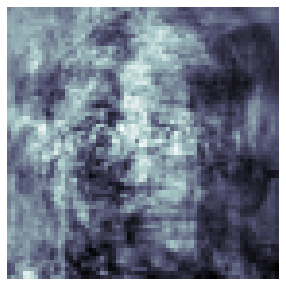

In [37]:
imme = Image.open("TestIm.jpg")
np_im = numpy.array(imme)[:,:,:3].astype(float) / 255
pl.figure()
pl.imshow(np_im[50:600,250:700,:] )
np_im[100:625,250:775,:].shape, np.prod(np_im.shape[1:]);
pl.show()

np_im_me = np_im[100:625,250:775,:][::15,::15,1]
pl.imshow(np_im_me, cmap="bone")
pl.axis('off');
pl.show()

pl.imshow(model.predict(np.array([np_im_me.flatten()])).reshape(70,70), 
          cmap="bone")
pl.axis('off');
pl.show()

In [0]:
imme = Image.open("sumo1.JPG")

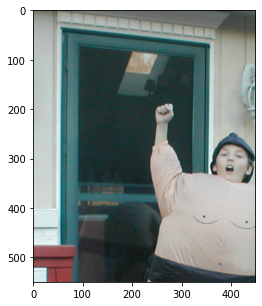

In [30]:

np_im = numpy.array(imme)[:,:,:3].astype(float) / 255
pl.figure()
pl.imshow(np_im[50:600,250:700,:] )
np_im[100:625,250:775,:].shape, np.prod(np_im.shape[1:]);


low resolution version
subsampling by 15

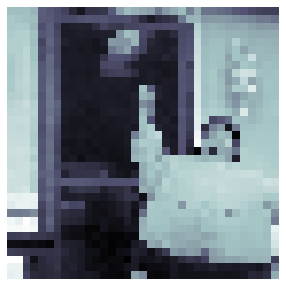

In [31]:
np_im_me = np_im[100:625,250:775,:][::15,::15,1]
pl.imshow(np_im_me, cmap="bone")
pl.axis('off');

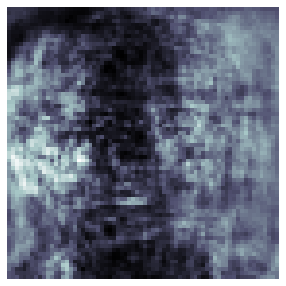

In [32]:
pl.imshow(model.predict(np.array([np_im_me.flatten()])).reshape(70,70), 
          cmap="bone")
pl.axis('off');

# ... not good at all :-( why??